In [381]:
import jax
import chex
import pandas as pd
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

In [382]:
%config InlineBackend.figure_format = "retina"
sns.set_palette("colorblind")
plt.rcParams["font.size"] = 16

## HMM Bernoulli


In [383]:
# Hidden Markov model
p_stay = 0.999
transition_matrix = jnp.array([
    [p_stay, 1 - p_stay], # state 0
    [1 - p_stay, p_stay], # state 1
])

In [384]:
# Probability of Bernoulli pay
proba_pay = jnp.array([
    [0.8, 0.2],
    [0.2, 0.8]
])

### Sampling from arms

In [385]:
key = jax.random.PRNGKey(314)
jax.random.bernoulli(key, p=proba_pay[0])

Array([ True, False], dtype=bool)

In [386]:
jax.random.bernoulli(key, p=proba_pay[0], shape=(1_000, 2)).mean(axis=0)

Array([0.78700006, 0.224     ], dtype=float32)

### Sampling from HMM

In [387]:
jax.random.choice(key, 2, p=transition_matrix[0])

Array(0, dtype=int32)

In [388]:
def step(ix, key):
    key_pay, key_change = jax.random.split(key)
    ix_new = jax.random.choice(key_change, 2, p=transition_matrix[ix])
    pay = jax.random.bernoulli(key_pay, p=proba_pay[ix_new])

    res = {
        "ix": ix_new,
        "is_change": ix_new != ix,
        "pay": pay
    }
    return ix_new, res


def sample_hmm(key, n_steps):
    keys = jax.random.split(key, n_steps)
    ix = 0 # start in first state
    _, res = jax.lax.scan(step, ix, keys)
    return res

In [413]:
key = jax.random.PRNGKey(314)
res = sample_hmm(key, 1000)

In [414]:
res["ix"]

Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [415]:
# Where changes happened
jnp.argwhere(res["is_change"]).ravel()

Array([452, 986], dtype=int32)

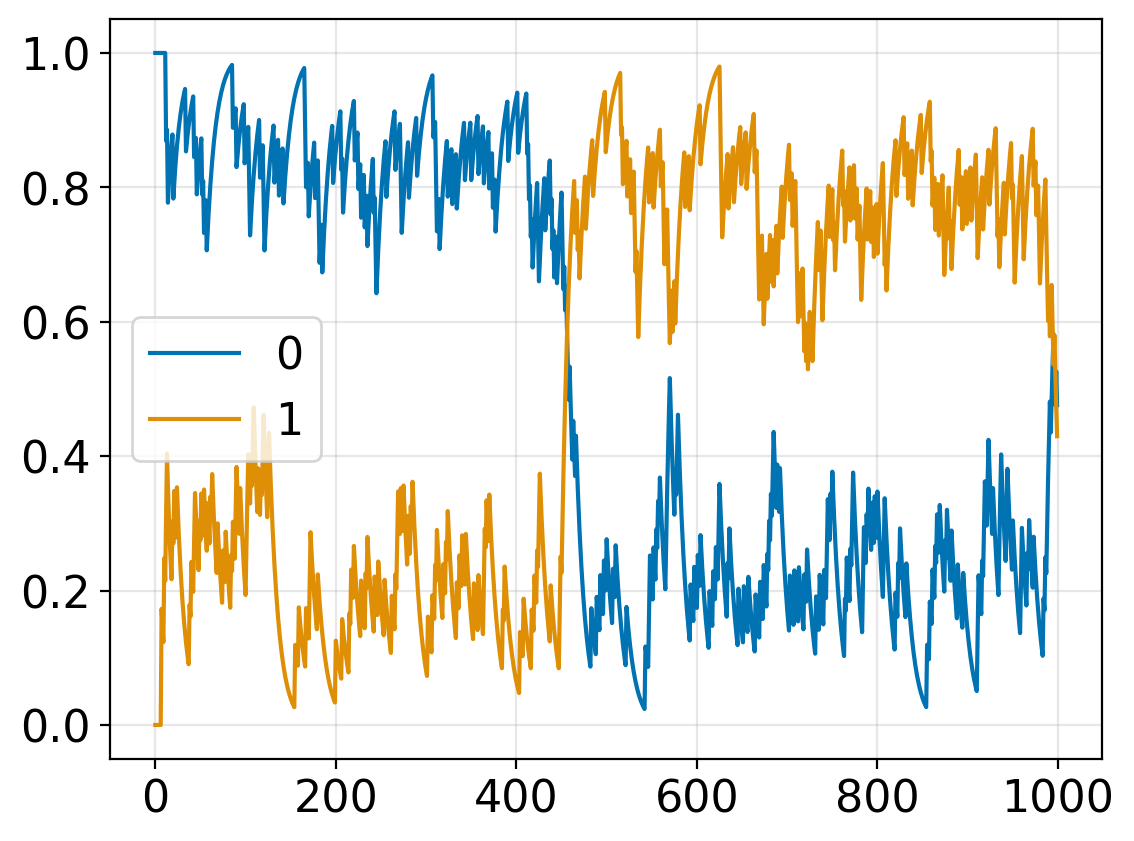

In [417]:
pd.DataFrame(res["pay"]).ewm(span=20).mean().plot()
plt.grid(alpha=0.3)

In [418]:
rewards = res["pay"]
rewards.shape

(1000, 2)

## Defining the state
This contains all the information we need to update the agent

In [419]:
@chex.dataclass
class BanditState:
    count: jax.Array # number times armed has been pulled
    value: jax.Array # sum of total rewards

    def update(self, action, value):
        state = self.replace(
            count=self.count.at[action].set(self.count[action] + 1),
            value=self.value.at[action].set(value)
        )
        return state

## Next, we begin defining the Epsilon-greedy bandit

In [420]:
class EpsilonGreedyBandit:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def init(self, n_arms):
        count = jnp.zeros(n_arms)
        value = jnp.zeros(n_arms)
        return BanditState(count=count, value=value)

In [421]:
bandit = EpsilonGreedyBandit(epsilon=0.1)
bandit_state = bandit.init(n_arms=10)
bandit_state

BanditState(count=Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), value=Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

## We now define the step function

In [422]:
class EpsilonGreedyBandit:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def init(self, n_arms):
        count = jnp.zeros(n_arms)
        value = jnp.zeros(n_arms)
        return BanditState(count=count, value=value)

    def step(self, state, xs, storefn):
        key, reward = xs

        key_choice, key_arm = jax.random.split(key)
        
        is_greedy = jax.random.bernoulli(key_choice, p=1 - self.epsilon)
        n_bandits = state.reward.shape[-1]
        random_choice = jax.random.choice(key_arm, n_bandits)

        action = state.value.argmax() * is_greedy + random_choice * (1 - is_greedy) 
        reward_arm = reward[action] # the reward we observe
        new_count = state.count[action] + 1

        discount = 1 / new_count
        new_value = state.value[action] + (reward_arm - state.value[action]) * discount
        
        state = state.update(action, new_value)
        carry = storefn(state, action, reward)

        return state, carry

## Next, the run function

In [423]:
class EpsilonGreedyBandit:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def init(self, n_arms):
        count = jnp.zeros(n_arms)
        value = jnp.zeros(n_arms)
        return BanditState(count=count, value=value)

    def step(self, state, xs, storefn):
        key, reward = xs

        key_choice, key_arm = jax.random.split(key)
        
        is_greedy = jax.random.bernoulli(key_choice, p=1 - self.epsilon)
        n_bandits = state.value.shape[-1]
        random_choice = jax.random.choice(key_arm, n_bandits)

        action = state.value.argmax() * is_greedy + random_choice * (1 - is_greedy) 
        reward_arm = reward[action] # the reward we observe
        new_count = state.count[action] + 1

        discount = 1 / new_count
        new_value = state.value[action] + (reward_arm - state.value[action]) * discount

        state = state.update(action, new_value)
        carry = storefn(state, action, reward)

        return state, carry

    def run(self, state_init, key, rewards, storefn):
        keys = jax.random.split(key, len(rewards))
        xs_hist = (keys, rewards)
        _step = partial(self.step, storefn=storefn)
        _, hist = jax.lax.scan(_step, state_init, xs_hist)
        return hist

    @partial(jax.jit, static_argnames=("self", "storefn"))
    def init_and_run(self, key, rewards, storefn):
        _, n_arms = rewards.shape
        state_init = self.init(n_arms)
        hist = self.run(state_init, key, rewards, storefn)
        return hist

## Test the bandit

In [424]:
bandit = EpsilonGreedyBandit(epsilon=0.05)

In [425]:
key = jax.random.PRNGKey(314)

def storefn(state, action, reward):
    return state, reward[action]
    
state_hist, rewards_bandits = bandit.init_and_run(key, rewards, storefn)

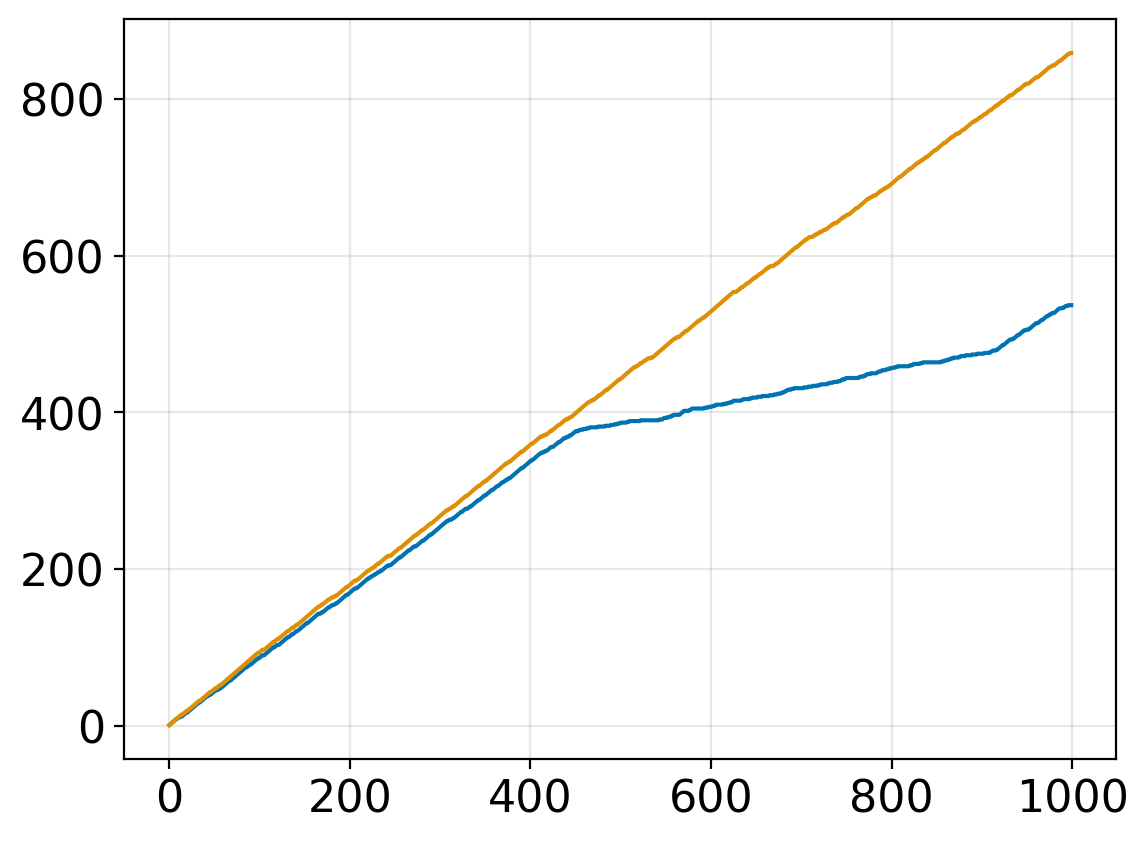

In [426]:
plt.plot(rewards_bandits.cumsum(), label="bandit")
plt.plot(rewards.max(axis=1).cumsum(), label="oracle")
plt.grid(alpha=0.3)

In [427]:
rewards_bandits.sum()

Array(537, dtype=int32)

In [428]:
rewards.max(axis=1).sum()

Array(859, dtype=int32)

## Make it non-stationary

In [429]:
class EpsilonGreedyBandit:
    def __init__(self, epsilon, alpha=0.0):
        self.epsilon = epsilon
        self.alpha = alpha

    def init(self, n_arms):
        count = jnp.zeros(n_arms)
        value = jnp.zeros(n_arms)
        return BanditState(count=count, value=value)

    def step(self, state, xs, storefn):
        key, reward = xs

        key_choice, key_arm = jax.random.split(key)
        
        is_greedy = jax.random.bernoulli(key_choice, p=1 - self.epsilon)
        n_bandits = state.value.shape[-1]
        random_choice = jax.random.choice(key_arm, n_bandits)

        action = state.value.argmax() * is_greedy + random_choice * (1 - is_greedy) 
        reward_arm = reward[action] # the reward we observe
        
        new_count = state.count[action] + 1
        discount = (1 / new_count) * (self.alpha == 0.0) + self.alpha
        new_value = state.value[action] + (reward_arm - state.value[action]) * discount

        state = state.update(action, new_value)
        carry = storefn(state, action, reward)

        return state, carry

    def run(self, state_init, key, rewards, storefn):
        keys = jax.random.split(key, len(rewards))
        xs_hist = (keys, rewards)
        _step = partial(self.step, storefn=storefn)
        _, hist = jax.lax.scan(_step, state_init, xs_hist)
        return hist

    @partial(jax.jit, static_argnames=("self", "storefn"))
    def init_and_run(self, key, rewards, storefn):
        _, n_arms = rewards.shape
        state_init = self.init(n_arms)
        hist = self.run(state_init, key, rewards, storefn)
        return hist

In [430]:
bandit = EpsilonGreedyBandit(epsilon=0.05, alpha=0.3)

In [431]:
key = jax.random.PRNGKey(314)

def storefn(state, action, reward):
    return state, reward[action]
    
state_hist_ns, rewards_bandits_ns = bandit.init_and_run(key, rewards, storefn)

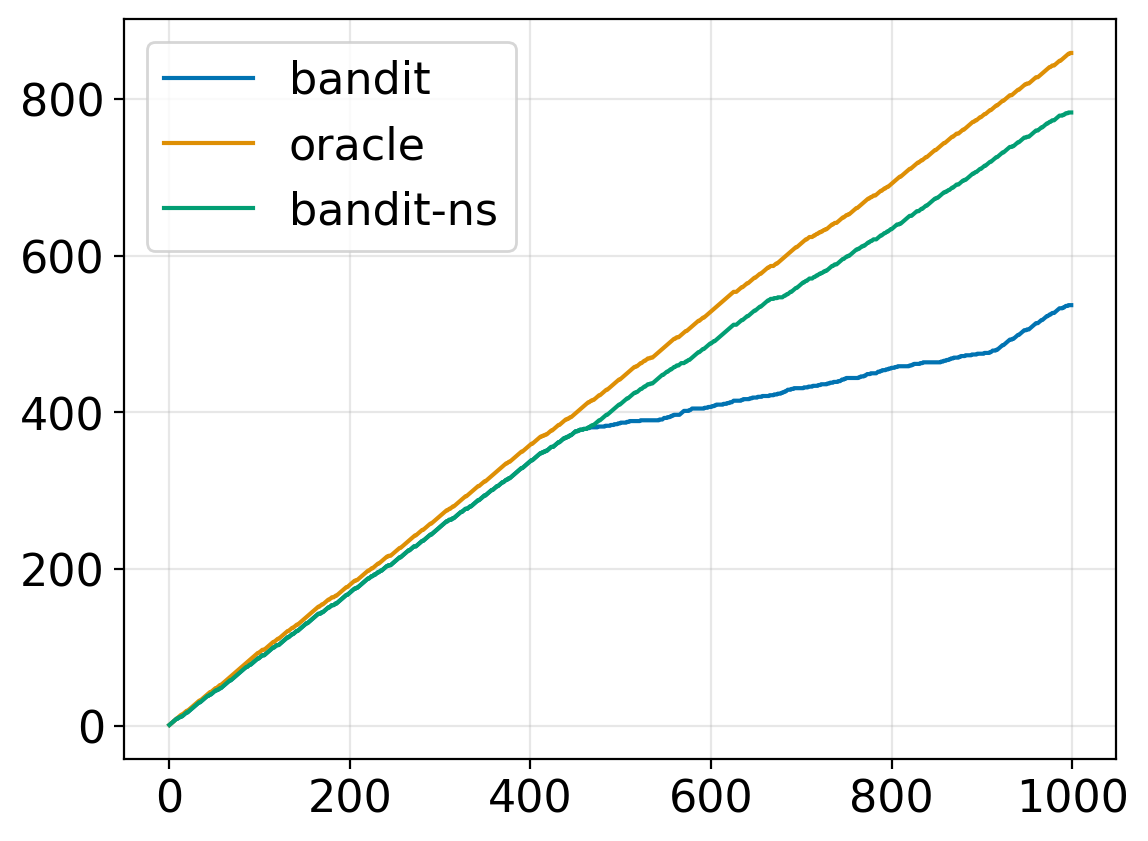

In [432]:
plt.plot(rewards_bandits.cumsum(), label="bandit")
plt.plot(rewards.max(axis=1).cumsum(), label="oracle")
plt.plot(rewards_bandits_ns.cumsum(), label="bandit-ns")
plt.legend()
plt.grid(alpha=0.3)